# Forecasting Australia's 2019 Election with PyMC3
#### Martin Burgess

## Overview
* Probabilistic forecasting
* Australian election primer
* Building a model in PyMC3

## Motivation
After my talk, I hope you will:
1. understand some the benefits of _probabilistic_ forecasting
2. see how easy it is to build probabilistic models using PyMC3.

### What is probabilistic forecasting?

Rather than trying to identify the single most likely outcome, probabilistic forecasting tries to estimate the relative probabilities of all outcomes.

<table style="float:right; width: 50%">
<tr>
    <td> <img style="float: left; width: 90%" src="../img/weather-1.png"> </td>
    </tr>
</table> 
<br>
Weather forecasts are probabilistic. 

They provide the relative probabilities of two different outcomes: rain and no rain.





### Why forecast probabilistically? 

The future is uncertain. Probabilistic forecasting give you a really clear idea of uncertainty. 


### Why forecast probabilistically? 

If we just forecast the most likley outcome, we don't have a clear sense of how much more likely it is than other outcomes. 
<table style="height:50%">
<tr>
    <td style="width: 50%"> <img style="float:right; width:100%" src="../img/newspoll.png"> </td>
    <td style="width: 50%"> <img style="float:left; width:100%" src="../img/buckleys.png"> </td>
    </tr>
</table>

### Make better decisions
<br>
<table style="float:right; width:50%">
<tr>
    <td style="width: 50%"> <img style="width:100%" src="../img/bet.png"> <img style="width:100%" src="../img/money.gif"> </td>    </tr>
</table>


Understanding uncertainty and forecasting probabilistically can help you make better decisions. 

You can identify how much *much likely* one outcome is from another, instead of just the most likely outcome. 
    


## Australian Election's Primer
### 151 seats

<table style="height:50%">
<tr>
    <td style="width: 50%"> Three groups:
<p style="color:#1c4f9c">Coalition (Liberal and National parties) </p>
<p style="color:#e53440">Australian Labor Party </p>
Crossbench (anyone else) </td>
    <td style="width: 50%"> <img style="float:right; width: 50%" src="../img/seats.svg"></td>
    </tr>
</table>




Two-party preferred

## Building a model in PyMC3

In [1]:
import pymc3 as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statistics import mean
import theano.tensor as tt
import arviz as az
# %matplotlib inline

### Step One: Aggregate polls (bayesian parameter estimation)

In [3]:
polls = pd.read_csv('../data/polls2019.csv').drop(['next_election', 'days_to_next'], axis=1)
polls['tpp_adjusted'] = polls['tpp_margin'] -  polls['bias']
polls.tail()

,start_date,end_date,firm,tpp_alp,tpp_lnc,tpp_margin,bias,std,tpp_adjusted
17,2019-05-09,2019-05-11,newspoll,0.510,0.490,-0.02,-0.005556,0.024673,-0.014444
18,2019-05-10,2019-05-12,morgan,0.520,0.480,-0.04,-0.058857,0.032881,0.018857
19,2019-05-10,2019-05-14,essential,0.515,0.485,-0.03,-0.020333,0.012291,-0.009667
20,2019-05-12,2019-05-15,ipsos,0.510,0.490,-0.02,-0.008000,0.017889,-0.012000
21,2019-05-16,2019-05-17,newspoll,0.515,0.485,-0.03,0.000588,0.022178,-0.030588


#### Look at the data. 

Mean polling two-party preferred margin: -0.6% (ALP Win)
Actual two-party preferred margin: 3.1% (COA Win)


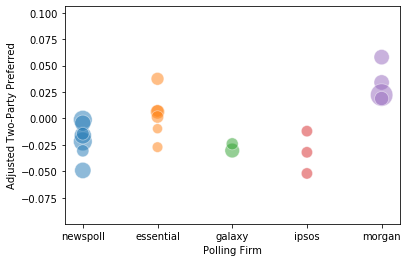

In [6]:
ax = sns.scatterplot(x='firm', y='tpp_adjusted', size='std', hue='firm', sizes=(100,500), alpha=0.5, legend=False, data=polls, )
ax.set(xlabel = "Polling Firm", ylabel="Adjusted Two-Party Preferred")
print("Mean polling two-party preferred margin: {:.1f}% (ALP Win)".format((polls['tpp_adjusted'].mean()*100)))
print("Actual two-party preferred margin: {:.1f}% (COA Win)".format(51.53-48.47))

Each dot represents a poll.
Across the x-axis are the five pollsters included in the forecast

Changes:
- Add zero line

<b>We are trying to combine these polls into a probabilistic estimate of the two-party preferred vote.</b>

BAYESIAN METHOD
1. Specify a prior
2. Update prior based on your data

IMPORT PYMC3

In [6]:
import pymc3 as pm

#### Specify a prior.

In [46]:
with pm.Model() as tpp_model: # explain "with"
    tpp_margin = pm.Uniform('tpp_margin', lower=-1, upper=1)
    trace = pm.sample(draws=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tpp_margin]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 3442.12draws/s]


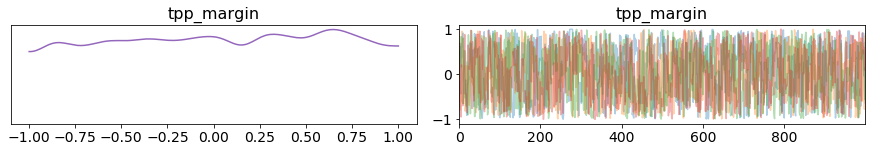

In [47]:
_ = pm.traceplot(trace, combined=True, compact=False)

_An uniformative prior_

_Notes_:
- This is a probability density function.
- Along the x-axis are all the possible values of the two-party preferred margin. 
- The y-axis represents the relative probability of the different values
- You can see here that all values from -1 to 1 have similar probabilities because we haven't included any data in the model yet.

#### We can ask some questions of this prior, before our model has seen any data. 
What is the probability the Coaltion win the two-party preferred vote?

In [49]:
print("Coalition win: {:.2f}%".format((trace['tpp_margin'] > 0).mean()*100))
print("Labor win: {:.2f}%".format((trace['tpp_margin'] < 0).mean()*100))

Coalition win: 51.32%
Labor win: 48.68%


With more samples these would approach 50/50

#### Specify a likelihood and add some data

In [50]:
with pm.Model() as tpp_model: # explain "with"
    tpp_margin = pm.Uniform('tpp_margin', lower=-1, upper=1)
    tpp_likelihood = pm.Normal('tpp_likelihood', tpp_margin, sd = polls['std'], observed = polls['tpp_adjusted'])
    # tpp_margin refers to the random variable we specified above
    trace = pm.sample(draws=1000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tpp_margin]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:02<00:00, 3050.95draws/s]


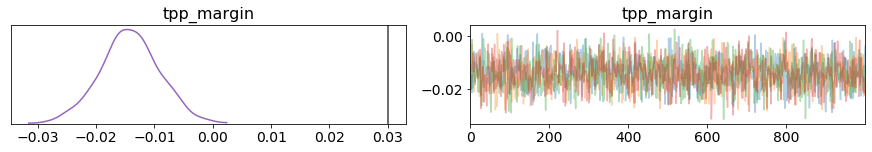

In [51]:
_ = pm.traceplot(trace,combined=True,  var_names = ['tpp_margin'], lines=[('tpp_margin', {}, [0.03])])

* I've noted the actual result from the election: the Coalition winning with a margin of 3% (51.5% to 48.5%)
* You can see our estimate doesn't give any probability to the actual two-party preferred outcome
* I'll discuss this a little more later but it mostly reflects the inaccuracies of polling
* This gives an idea of what we predict the two-party preferred vote will be, can we still use it to predict the number of seats each party will win at an election?

## THANK YOU FOR COMING, THIS HAS BEEN MY TED TALK 

### From the two-party preferred vote to the seats a party will win (Bayesian linear regression)

#### Look at the data.

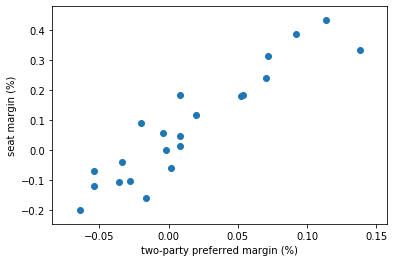

In [21]:
past_elections = pd.read_csv('../data/election_data.csv', index_col='date')
past_elections = past_elections.tail(22)
# past_elections[['tpp_margin', 'seat_margin_pc_majors']].tail()
_ = plt.scatter(past_elections['tpp_margin'], past_elections['seat_margin_pc_majors'])
_ = plt.xlabel("two-party preferred margin (%)")
_ = plt.ylabel("seat margin (%)")

#### Fit a line. 
\begin{align}
\\y & = slope \times x +\ intercept\\
\\y & = 3.05 \times x +\ 0.03\\
\end{align}

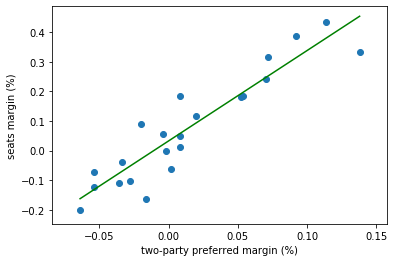

In [30]:
_ = plt.scatter(past_elections['tpp_margin'], past_elections['seat_margin_pc_majors'])
_ = plt.plot(np.unique(past_elections['tpp_margin']), np.poly1d(np.polyfit(past_elections['tpp_margin'], past_elections['seat_margin_pc_majors'], 1))(np.unique(past_elections['tpp_margin'])),color="green")
_ = plt.xlabel("two-party preferred margin (%)")
_ = plt.ylabel("seats margin (%)")

#### Specify priors.

In [32]:
with pm.Model() as linreg_model:
    slope = pm.Normal('slope', 0, sd=10)
    intercept = pm.Normal('intercept', 0, sd=10)
    sigma = pm.HalfCauchy('sigma', 1)
    trace = pm.sample(draws=1000, cores=4)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, intercept, slope]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:02<00:00, 2444.96draws/s]


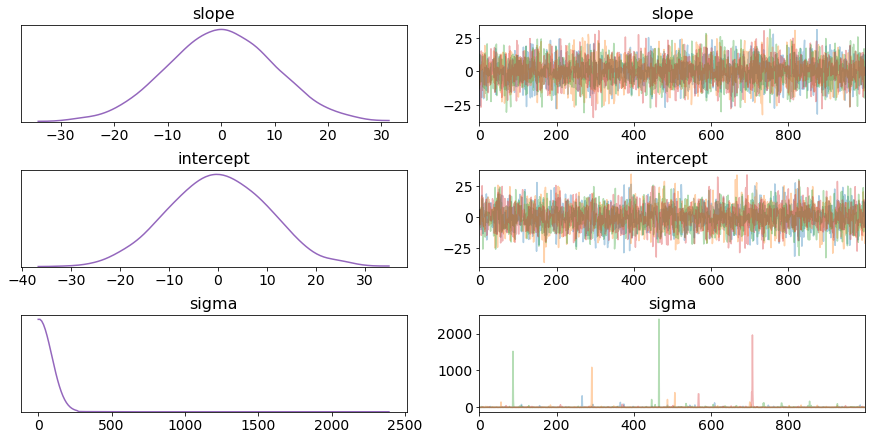

In [33]:
_ = pm.traceplot(trace, combined=True)

#### Specify likelihood.

In [34]:
with linreg_model:
    y = intercept + slope * past_elections['tpp_margin']

    # tpp2seat likelihood
    tpp2seat_like = pm.Normal('linreg_likelihood', y, sd = sigma, observed = past_elections['seat_margin_pc_majors'])
    trace = pm.sample(draws=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, intercept, slope]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:04<00:00, 1429.36draws/s]


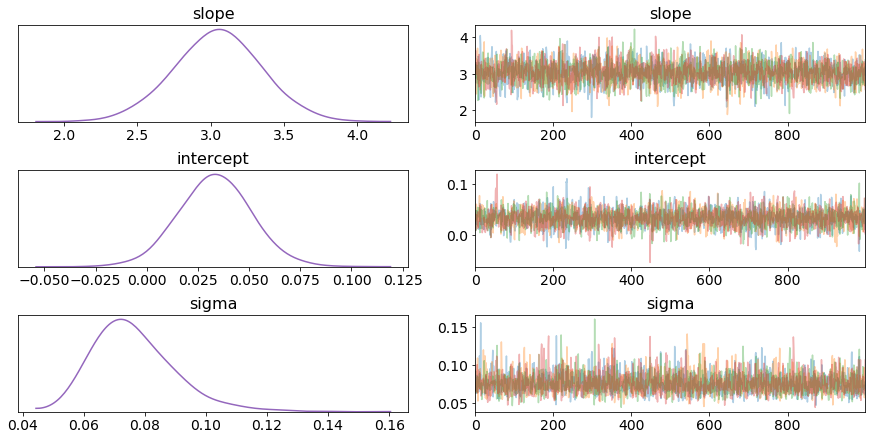

In [35]:
_ = pm.traceplot(trace, combined=True)

In [36]:
df = pm.trace_to_dataframe(trace)

In [86]:
df['slope'].describe()
df['intercept'].describe()

count    4000.000000
mean        0.051971
std         0.012513
min         0.006959
25%         0.043480
50%         0.052218
75%         0.060216
max         0.100132
Name: intercept, dtype: float64

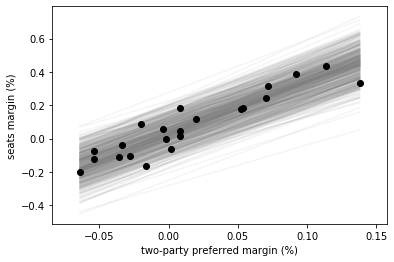

In [41]:
_ = plt.scatter(past_elections['tpp_margin'], past_elections['seat_margin_pc_majors'], color='black', zorder=501)

for i in range(500):
    line_x = pd.DataFrame([past_elections['tpp_margin'].min(), past_elections['tpp_margin'].max()])
    line_y = line_x * df.loc[i,'slope'] + df.loc[i,'intercept'] + np.random.normal(loc=0.0, scale=df.loc[i,'sigma'])
    _ = plt.plot(line_x, line_y, color='grey', alpha=0.08, zorder=500-i)
_ = plt.xlabel("two-party preferred margin (%)")
_ = plt.ylabel("seats margin (%)")

### Crossbench

In [177]:
crossbench_stats = pd.read_csv('../data/crossbench_stats.csv', index_col=0)
with pm.Model() as all_together:
    p_retain = pm.Beta('p_retain', alpha=1, beta=1)
    crossbench_retain_like = pm.Binomial('crossbench_retain_like', n=crossbench_stats['crossbench_running'], p=p_retain, observed=crossbench_stats['crossbench_retain'])
    crossbench_retain = pm.Binomial('crossbench_retain', n=6, p=p_retain)

    p_gain = pm.Beta('p_gain', alpha=1, beta=1)
    crossbench_gain_like = pm.Binomial('crossbench_gain_like', n=crossbench_stats['gain_opportunities'], p=p_gain, observed=crossbench_stats['crossbench_gain'])
    crossbench_gain = pm.Binomial('crossbench_gain', n=145, p=p_gain)

    crossbench_total = pm.Deterministic('crossbench_total', crossbench_gain + crossbench_retain)
#     trace = pm.sample(draws=1000, cores=4)
# _ = pm.traceplot(trace, combined=True,var_names=['crossbench_total'])

### Putting it all together

In [178]:
with all_together:
    #estimate tpp_margin
    tpp_margin = pm.Uniform('tpp_margin', lower=-1, upper=1) #prior
    errors = polls['tpp_margin'].values - tpp_margin

            # tpp_margin likelihood
    tpp_margin_like = pm.Normal('tpp_margin_like', errors, sd = polls['std'], observed = polls['bias'])
#     tpp_likelihood = pm.Normal('tpp_likelihood', tpp_margin, sd = polls['std'], observed = polls['tpp_adjusted']) #likelihood

    #estimate linear relationship between tpp_margin and seat_margin
    slope = pm.Normal('slope', 0, sd=10) #prior
    intercept = pm.Normal('intercept', 0, sd=10) #prior
    sigma = pm.HalfCauchy('sigma', 1) #prior
    y = intercept + slope * past_elections['tpp_margin'] #define relationship
    tpp2seat_like = pm.Normal('linreg_likelihood', y, sd = sigma, observed = past_elections['seat_margin_pc_majors']) #likelihood
    
    # estimate seat_margin
    seat_margin_pc = pm.Normal('seat_margin_pc', intercept + slope * tpp_margin, sd = sigma) #combine estimates
    
    majors_seats = (151.0 - crossbench_total)
    seat_margin_temp = majors_seats * seat_margin_pc
    alp_seats = pm.Deterministic('alp_seats', tt.round((majors_seats/2.0) - (seat_margin_temp/2.0)).astype('int8'))
    lnc_seats = pm.Deterministic('lnc_seats', tt.round((majors_seats/2.0) + (seat_margin_temp/2.0)).astype('int8'))

    majors_seat_margin = pm.Deterministic('majors_seat_margin', lnc_seats - alp_seats)
    trace = pm.sample(draws=5000,tune=1000, cores=4)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [seat_margin_pc, sigma, intercept, slope, tpp_margin, p_gain, p_retain]
>CompoundStep
>>Metropolis: [crossbench_gain]
>>Metropolis: [crossbench_retain]
Sampling 4 chains: 100%|██████████| 24000/24000 [00:49<00:00, 482.75draws/s]
The number of effective samples is smaller than 25% for some parameters.


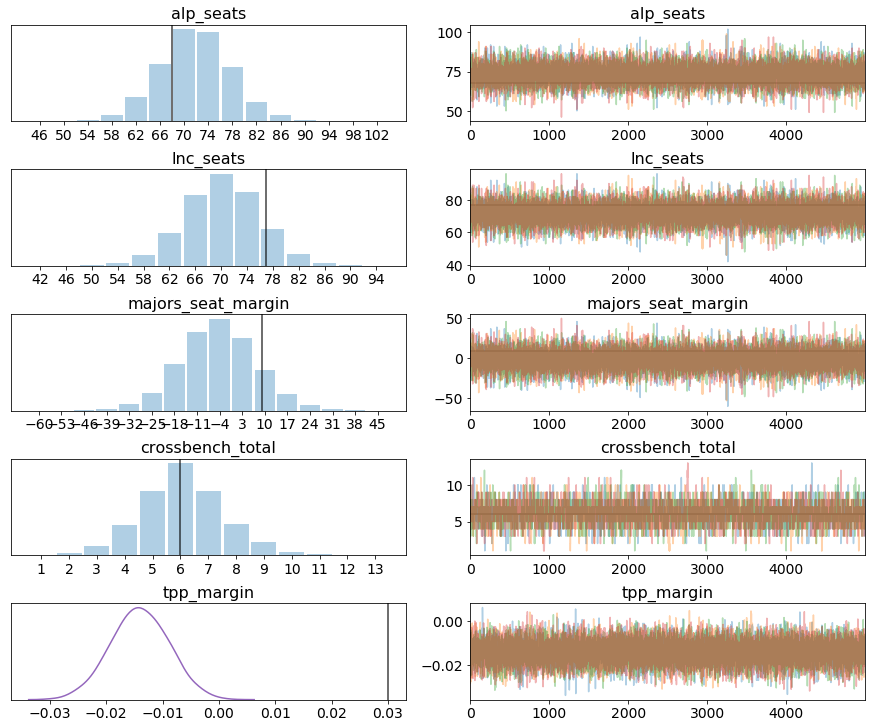

In [197]:
_ = pm.traceplot(trace, combined=True, var_names=['alp_seats', 'lnc_seats', 'majors_seat_margin', 'crossbench_total', 'tpp_margin'], lines=[('alp_seats', {}, [68]), ('lnc_seats', {}, [77]), ('majors_seat_margin', {}, [9]), ('crossbench_total', {}, [6]), ('tpp_margin', {}, [0.03])])

In [186]:
(49.29 - 50.71)/100

-0.014200000000000016

* dates poll was in the field
* firm
* two-party preferred results as decimal
    * ALP
    * LNC
    * Margin = LNC - ALP
* tpp_margin = two-party preferred margin reported by the poll
* bias = an estimate of how "biased" this poll is. It is estimated by averaging the accuracy of polls by the same pollster a similar number of days out from an election (days_to_election)
* std = an estimate of the standard deviation of this poll. This is calculated using the same polls as the bias calculation. The smaller the standard deviation the more this poll will move the forecast. 

Steps:
1. Calculate margin
2. Calculate bias (not covered)
3. Adjust margin based on bias

PERHAPS DROP AND JUST HAVE ADJUSTED